# Rectangular Integration of RNA+ADT

In this tutorial, we demonstrate how to use MIDAS to integrate a dataset consisting of RNA (gene expression) and ADT (antibody-derived tags) data. We will walk through the entire process, from data setup and model training to inference and evaluation of the results.

## 1. Setting Up the Environment

First, we import the necessary libraries and configure the environment. This includes setting a specific CUDA device for GPU acceleration and ensuring reproducibility with a fixed random seed.

In [1]:
import os
import subprocess
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from scmidas.config import load_config
from scmidas.data import download_data, download_models
from scmidas.model import MIDAS

os.environ['CUDA_VISIBLE_DEVICES']='0'  # Set the GPU device to be used
sc.set_figure_params(figsize=(4, 4))    # Set plotting parameters for scanpy
L.seed_everything(42)                   # Set a global random seed for reproducibility

Seed set to 42


42

## 2. Downloading the Data

We will use a public dataset for this demonstration. The `task` variable defines the dataset name, which corresponds to a multi-batch (8 batches) RNA+ADT dataset in mtx format. The `download_data` function will automatically fetch and place it in the `dataset/` directory.

In [ ]:
task = 'wnn_full_8batch_mtx'
download_data(task)

## 3. Configuring the Model

Next, we configure the MIDAS model. We start by loading the default configuration, which contains optimized hyperparameters for various tasks. We then instruct the model where to find the data and where to save the trained model artifacts.

In [3]:
configs = load_config()
configs['num_workers'] = 8  # Adjust based on your system's CPU cores for data loading
model = MIDAS.configure_data_from_dir(configs=configs, dir_path='dataset/'+task+'/data',
                                      save_model_path='saved_models/'+task)

INFO:root:The model is initialized with the default configurations.
INFO:root:Input data: 
         #CELL  #ADT  #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   6378   224  3617         224        3617
BATCH 1   5899   224  3617         224        3617
BATCH 2   4628   224  3617         224        3617
BATCH 3   5285   224  3617         224        3617
BATCH 4   6952   224  3617         224        3617
BATCH 5   6060   224  3617         224        3617
BATCH 6   8854   224  3617         224        3617
BATCH 7   8908   224  3617         224        3617


## 4. Training the Model

We have two options: use a pre-trained model for a quick start or train the model from scratch to see the full process. For this demo, we will use the pre-trained version. To train from scratch, simply set `use_pretrained = False`

In [ ]:
use_pretrained = True # To train from scratch, set it to False

if use_pretrained:
    download_models(task)
    model.load_checkpoint(f'saved_models/{task}.pt')
else:
    trainer = L.Trainer(max_epochs=1500)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    trainer.fit(model=model)

## 5. Generating Predictions

With a trained model, we can now perform inference.

### 5.1 Joint Embeddings and Batch-Corrected Data

We infer the joint embedding `z`, which is composed of a biological component `c` and a technical component `u`. We also generate the batch-corrected count data.

In [ ]:
# `joint_latent=True`: Generate the joint embeddings.
# `batch_correct=True`: Generate batch-corrected count data.
# `input=True`: Keep the original input data (for later use).
predicted_bc = model.predict(joint_latent=True, batch_correct=True, input=True)

### 5.2 Modality-Specific Embeddings

We infer the embeddings for each data modality (RNA and ADT) separately.

In [ ]:
# `mod_latent=True`: Generate modality-specific embeddings.
# `group_by='batch'`: Organise the predictions by batch (for later use).
predicted_mod = model.predict(mod_latent=True, group_by='batch')

## 6. Visualizing the Results

Now, let's visualize the outputs to assess the model's performance. First, we need to load the cell-type labels and batch identifiers for annotation.

In [7]:
label = []
batch_id = []
for i in [f'p{j}_0' for j in range(1,9)]:
    label.append(pd.read_csv('dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten())
    batch_id.append([i] * len(label[-1]))
labels = np.concatenate(label)
batch_ids = np.concatenate(batch_id)

### 6.1 Joint Embeddings

The joint embedding `z` is composed of two parts: `c` for the biological state and `u` for technical noise. A successful integration should show that:

- The **Biological State** embedding groups cells by their cell type (`label`), regardless of their original `batch`.

- The **Technical Noise** embedding captures batch effects, meaning cells should group by `batch`.

 We use UMAP to visualize these embeddings.

... storing 'batch' as categorical
... storing 'label' as categorical


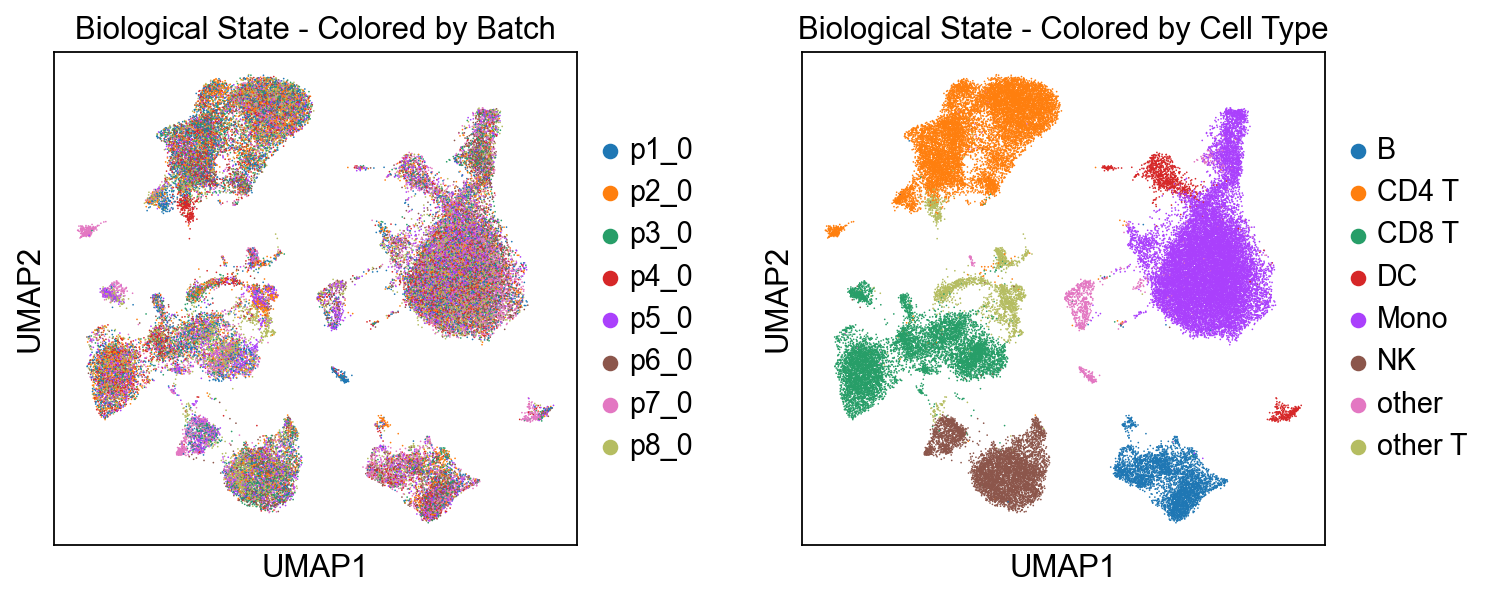

... storing 'batch' as categorical
... storing 'label' as categorical


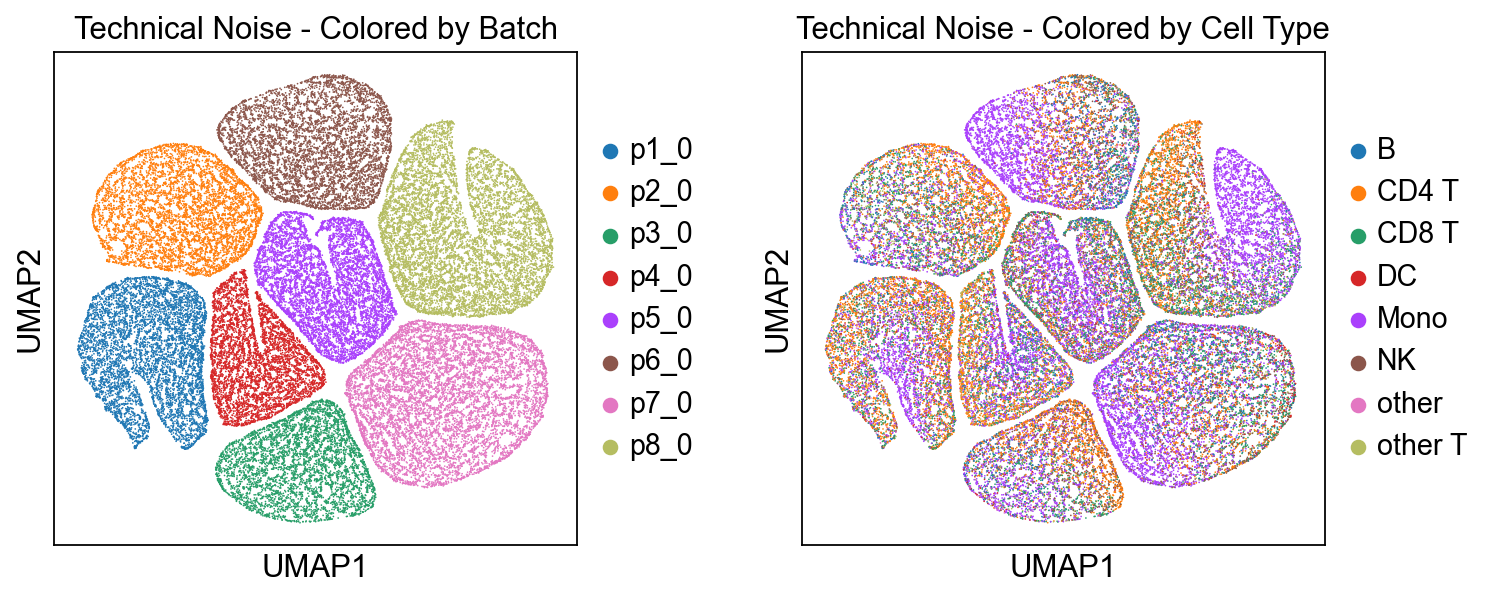

In [8]:
# Separate the biological and technical components of the joint embedding
z_joint = {"Biological State": sc.AnnData(predicted_bc['z']['joint'][:, :model.dim_c]),
           "Technical Noise": sc.AnnData(predicted_bc['z']['joint'][:, model.dim_c:])}

# Plot UMAP for each component
for k, adata in z_joint.items():
    adata.obs['batch'] = batch_ids
    adata.obs['label'] = labels
    sc.pp.subsample(adata, fraction=1)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['batch', 'label'], ncols=2, wspace=0.3,
               title=[f'{k} - Colored by Batch', f'{k} - Colored by Cell Type'])

### 6.2 Modality-Specific Embeddings

Here, we visualize the biological embeddings (`c`) for each modality (RNA, ADT) and for the joint representation, across all 8 batches. This helps us understand how well-aligned the different modalities are within each batch after being projected into the common latent space.

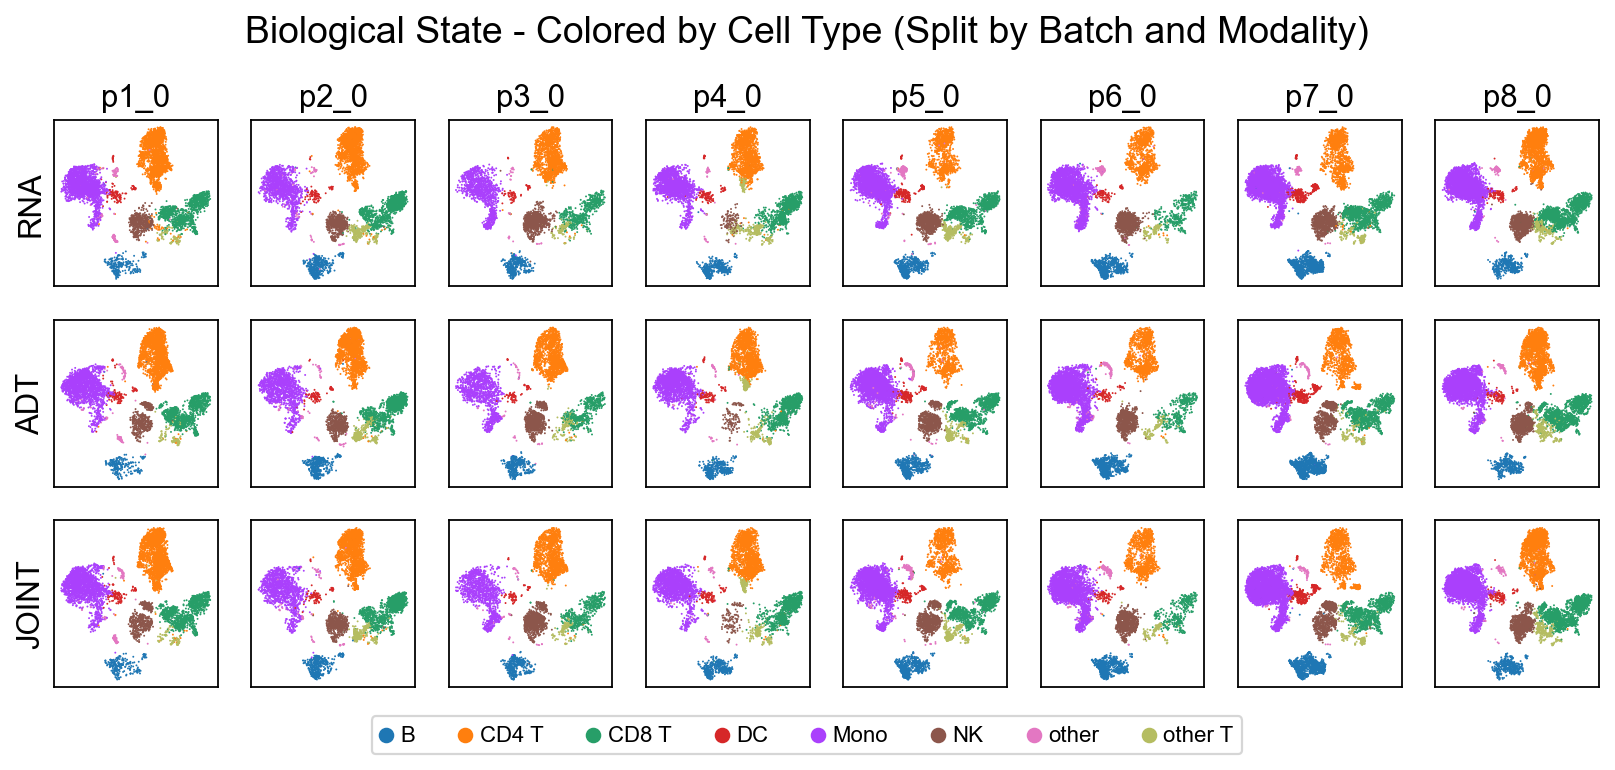

In [9]:
# Consolidate modality-specific embeddings into a single AnnData object for plotting
batch_names = [f'p{i}_0' for i in range(1,9)]
adata_dict = {}
for i in range(model.dims_s['joint']): # Iterate through batches
    for m in model.mods+['joint']: # Iterate through modalities (RNA, ADT, joint)
        if m in predicted_mod[i]['z']:
            # Create an AnnData object for the biological component of the latent space
            adata = sc.AnnData(predicted_mod[i]['z'][m][:, :model.dim_c])
            adata.obs['batch'] = batch_names[i]
            adata.obs['modality'] = m
            adata.obs['label'] = label[i]
            adata_dict[f"{batch_names[i]}_{m}"] = adata

# Concatenate all AnnData objects
adata_mod_concat = sc.concat(adata_dict, index_unique="-")
for col in adata_mod_concat.obs.columns:
    adata_mod_concat.obs[col] = adata_mod_concat.obs[col].astype('category')

# Compute neighbors and UMAP on the combined data
sc.pp.neighbors(adata_mod_concat, use_rep='X')
sc.pp.subsample(adata_mod_concat, fraction=1) # Shuffle data
sc.tl.umap(adata_mod_concat)

# Setup the figure for plotting
nrows = len(model.mods) + 1
ncols = model.dims_s['joint']
point_size = 3
fig, ax = plt.subplots(nrows, ncols, figsize=[1.5 * ncols, 1.5 * nrows])

# Iteratively create a UMAP scatter plot for each batch and modality
mod_names = model.mods + ['joint']
for i, mod in enumerate(mod_names):
    for b in range(model.dims_s['joint']):
        # Filter the data for the current modality and batch
        adata_subset = adata_mod_concat[
            (adata_mod_concat.obs['modality'] == mod) & 
            (adata_mod_concat.obs['batch'] == batch_names[b])
        ].copy()
        
        ax_current = ax[i, b]
        if len(adata_subset) > 0:
            sc.pl.umap(adata_subset, color='label', show=False, ax=ax_current, s=point_size, title="")
            ax_current.get_legend().set_visible(False)
            # Store legend handles from one of the plots to create a global legend
            if i == 0 and b == 0:
                handles, labels_ = ax_current.get_legend_handles_labels()
        
        # Clean up axes
        ax_current.set_xticks([])
        ax_current.set_yticks([])
        ax_current.set_xlabel('')
        
        # Set row and column titles
        if b == 0:
            ax_current.set_ylabel(mod.upper())
        else:
            ax_current.set_ylabel('')
        if i == 0:
            ax_current.set_title(batch_names[b])
        else:
            ax_current.set_title('')

# Create a single, global legend for the entire figure
fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels_), fontsize=10)
fig.suptitle("Biological State - Colored by Cell Type (Split by Batch and Modality)")
plt.tight_layout(rect=[0.07, 0, 0.93, 1.03])
plt.show()

### 6.3 Batch-Corrected Data vs. Original Data

To externally validate the quality of MIDAS's batch-corrected count data, we will use a third-party algorithm, Seurat's Weighted Nearest Neighbor (WNN), to compute joint embeddings from both the batch-corrected and original counts.

For efficiency, we'll use a random sample of 2000 cells for the comparison.

In [10]:
N = 2000
select = np.random.choice(list(range(len(predicted_bc['x_bc']['rna']))), N, replace=False)
adata = sc.AnnData(np.zeros([N, 1])) # Create a placeholder AnnData object for plotting

Now, we will loop through the batch-corrected and original data. For each, we save the subsampled data to disk, execute the R script to perform WNN and UMAP, and then load and plot the results.


Python: Executing R script 'wnn_bimodal.R' for Batch-Corrected Data...



... storing 'label' as categorical
... storing 'batch' as categorical


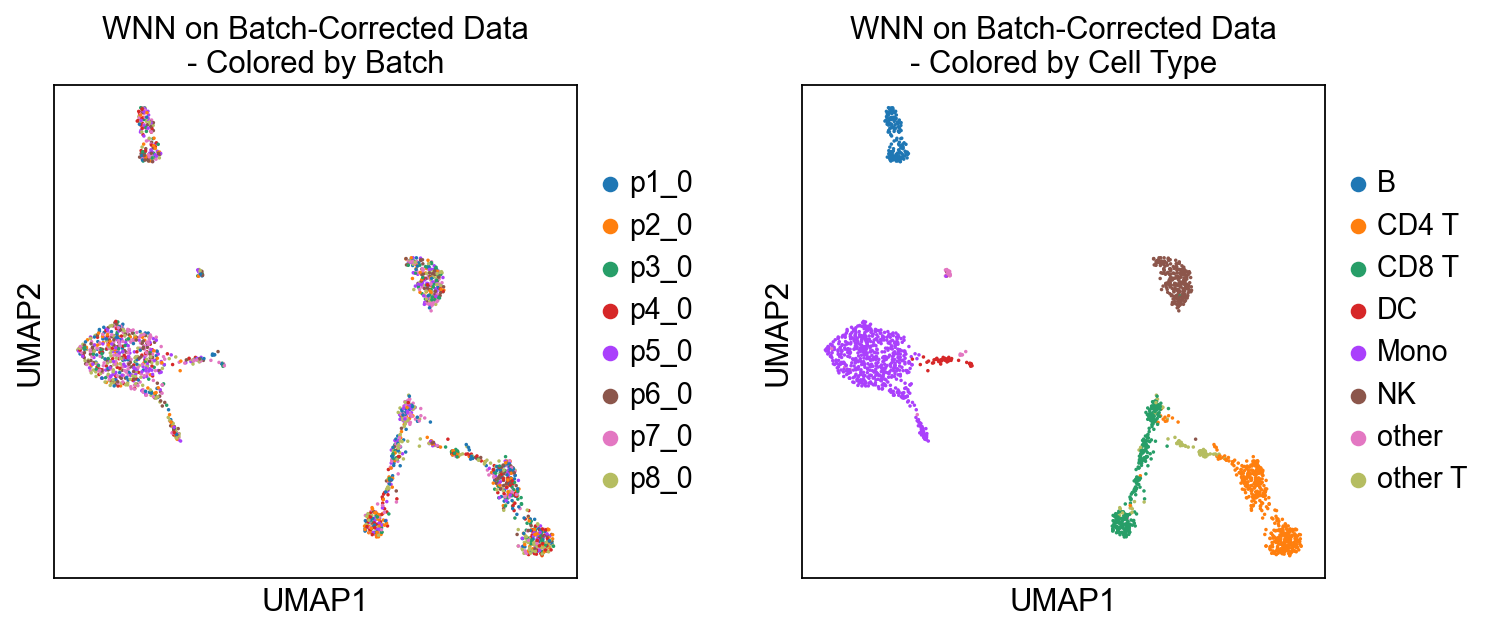


Python: Executing R script 'wnn_bimodal.R' for Original Data...



... storing 'label' as categorical
... storing 'batch' as categorical


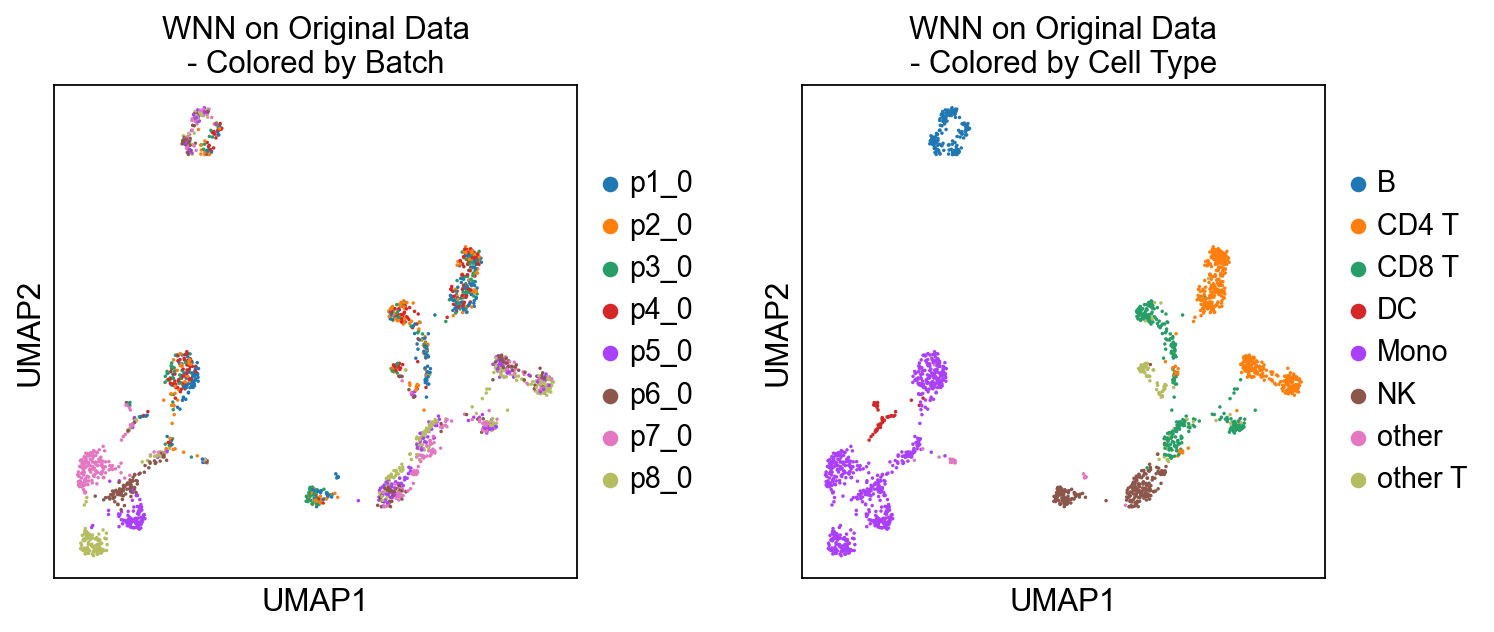

In [11]:
temp_dirs = {"Batch-Corrected Data": 'demo1_temp/x_bc/', "Original Data": 'demo1_temp/x/'}
r_script_file = 'wnn_bimodal.R' # R script for WNN analysis on RNA+ADT data

for name, temp_dir in temp_dirs.items():
    # 1. Save Python data to disk for the R script to access
    os.makedirs(temp_dir, exist_ok=True)
    data_key = Path(temp_dir).name  # 'x_bc' or 'x'
    pd.DataFrame(predicted_bc[data_key]['rna'][select]).T.to_csv(temp_dir+'rna.csv', index=True)
    pd.DataFrame(predicted_bc[data_key]['adt'][select]).T.to_csv(temp_dir+'adt.csv', index=True)

    # 2. Execute the R script via a subprocess
    print(f"\nPython: Executing R script '{r_script_file}' for {name}...\n")
    command = ['Rscript', '--vanilla', r_script_file, temp_dir]
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    # print(result.stdout) # uncomment this line to see the R script's output

    # 3. Load the UMAP results generated by R and plot them
    adata.obsm['X_umap'] = pd.read_csv(temp_dir+'umap_coords.csv', index_col=0).values
    adata.obs['label'] = labels[select]
    adata.obs['batch'] = batch_ids[select]
    sc.pp.subsample(adata, fraction=1) # Shuffle data
    sc.pl.umap(adata, color=['batch', 'label'], ncols=2, wspace=0.3, size=10,
               title=[f'WNN on {name}\n- Colored by Batch', f'WNN on {name}\n- Colored by Cell Type'])


The final UMAPs clearly demonstrate the effectiveness of MIDAS's batch correction:

- When WNN is applied to the **Batch-Corrected Data** generated by MIDAS, the batch effect is successfully removed. The cells in the UMAP now cluster primarily by `label` (cell type), revealing the underlying biological structure of the data.

- In contrast, when WNN is applied to the **Original Data**, the resulting UMAP shows strong separation by `batch`, indicating that technical artifacts are dominating the analysis. The biological cell-type structure is obscured by the batch effect.

This shows that MIDAS can produce batch-corrected data that is directly usable by standard downstream analysis tools like Seurat's WNN to achieve effective data integration.